# 1 Разделение набора данных на тренировочный, валидационный, тестовый

In [1]:
from pathlib import Path
import os
import tensorflow as tf

In [2]:
# ⚠️Копирование папки для логирования, при инициализации среды
# !cp -a ../input/mlflow-run/mlruns/. ./mlruns

In [3]:
path_data = Path('./data/')
path_models = Path('./models/')
path_mlflow = Path('./mlruns/')
path_img = Path('./img/')

paths = [path_data, path_models, path_mlflow, path_img]

for path in paths:
    if os.path.exists(path):
        print(f"Folder {path} exists!")
    else:
        os.makedirs(path)
        print(f"Folder {path} was created.")

Folder data was created.
Folder models was created.
Folder mlruns was created.
Folder img was created.


In [4]:
feature_description = {
    'description': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse_function(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  return (parsed['description'], parsed['label']) 

## Dataset & Гиперпараметры

In [5]:
path_input = Path('../input/imdb-tfrecord-1/')
path_input = Path('../input/imdb-tfrecord-2/')
path_input = Path('../input/imdb-tfrecord-3/')
path_input = Path('../input/imdb-tfrecord-4/')

In [6]:
filename_train_clean_encoded          = './train_clean_encoded.tfrecords'
filename_train_clean_encode_resampled = './train_clean_encode_resampled.tfrecords'
filename_test                         = './test_clean_encoded.tfrecords'

In [7]:
HP_DATASET = {'dataset_size_resampled' : 500_000,
              'max_features'           : 50_000, # Количество слов в словаре
              'max_sequence_length'    : 128,     # Ограничение длины описания фильма, не более X слов
              'batch_size'             : 1024,    # Можно уперется в объём GPU RAM
              'dataset_resampled'      : 'yes',   # Используется dataset с размноженными данными.
             }

HP_MODEL = {'embedding_dim'           : 16,      # Длина вектора для кодировки одного слова
            'h_size'                  : 256,      # Размер скрытой "памяти" в LSTM
            'drop_out'                : 0.3,      # Сколько нейронов отключать  
            'num_epochs'              : 20,       # Сколько эпох обучать
            'dense_before_out'        : 128,      # Слой перед классификатором
            'class_amount'            : 27,       # Количестов классов (жанры)
            'class_weight_fit'        : 'no',    # В fit передаются веса для классов
           }

CLASS_WEIGHT = {0: 0.1475, 1: 1.2621, 2: 3.4033, 3: 0.1533, 4: 0.2696, 5: 3.9761,
                6: 2.2714, 7: 0.911, 8: 4.648, 9: 4.032, 10: 1.5269, 11: 6.2165, 
                12: 0.3958, 13: 3.1034, 14: 2.7468, 15: 2.5909, 16: 5.1354, 17: 1.9457,
                18: 2.5611, 19: 6.2944, 20: 8.2631, 21: 11.0935, 22: 7.5771, 23: 2.988,
                24: 10.3501, 25: 7.2488, 26: 15.2116}

## 1.1 Тренировочный набор загрузка с диска TFRecords

Тренировочный набор данных TFRecords с upsample:
* слова закодированы, объем словаря и длина для эмбеддинга заданы на этапе подготовки.
* сделан `upsample` 50k -> 150k

Тренировочный набор TfRecorde без upsample:
* слова закодированы, как ранее.
* объем набора 50k.
* есть "веса для классов".

In [8]:
# ⚠️ Загрузка подготовленного ранее dataset с и без балансировки классов
path = str(path_input / filename_train_clean_encode_resampled)
# path = str(path_input / filename_train_clean_encoded)


train_ds = tf.data.TFRecordDataset(filenames = [path])
train_ds = train_ds.map(parse_function)
train_ds = train_ds.map(lambda x,y: (tf.io.parse_tensor(x, out_type=tf.int64), y))

# for i in train_ds.take(1):
#     print(i)
#     HP_DATASET['max_sequence_length'] = i[0].shape[0]

train_ds = train_ds.batch(HP_DATASET['batch_size'])
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

2022-08-06 10:12:04.390969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 10:12:04.539290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 10:12:04.543288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 10:12:04.551151: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 1.2 Загрузка тестового и валидационного

In [9]:
# Загрузка Тестового набора данных
path = str(path_input / filename_test)
test_val_ds = tf.data.TFRecordDataset(filenames = [path])
test_val_ds = test_val_ds.map(parse_function)
test_val_ds = test_val_ds.map(lambda x,y: (tf.io.parse_tensor(x, out_type=tf.int64), y))


# .shard() - разделить dataset на части в каждую часть войдут 1/num_shards - элементов.
val_ds = test_val_ds.shard(num_shards=2, index=0)
# .cache() - кешируем данные, чтобы не тратить время на валидации
val_ds = val_ds.cache()
# dataset.batch(512) - определяется размер батча
val_ds = val_ds.batch(HP_DATASET['batch_size'])
# Загружаем следующий набор заранее
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


test_ds = test_val_ds.shard(num_shards=2, index=1)
test_ds = test_ds.cache()
test_ds = test_ds.batch(HP_DATASET['batch_size'])
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# 2 Настройка MLFlow

## Установка

In [10]:
try:
    import mlflow
    print(mlflow.__version__)
except:
    print('Устанавливаю MLFlow, не забудь перезапустить ядро. НЕ Factory rest')
    from IPython.display import clear_output
    !pip install -U mlflow
    clear_output(wait=False)
    import mlflow

    print('Устанавил и импортировал MLFlow, перезапусти ядро (!)')

Устанавил и импортировал MLFlow, перезапусти ядро (!)


## Найстройка путей для трекинга

In [11]:
# Инициализация и установка места для логирования
path_mlflow_sql = path_mlflow / 'mlruns.db'
mlflow.set_tracking_uri(f"sqlite:///{path_mlflow_sql}")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: sqlite:///mlruns/mlruns.db


## ✅Установка эксперимента

In [12]:
# Установка эксперимента
exp_name = 'Base'
experiment_info = mlflow.set_experiment(experiment_name=exp_name)

# Получить информацию по названию эксперимента
# experiment_info = mlflow.get_experiment_by_name(exp_name)
print('Номер эксперимента: ',experiment_info.experiment_id)
print(experiment_info)

2022/08/06 10:12:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/08/06 10:12:30 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Номер эксперимента:  1
<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='Base', tags={}>


# 3 Архитектура сети

In [13]:
# Автологер для fit(), объявляется перед run ❗, до или после создания модели?
# ⚠️ Не срабатывает в Kaggle notebooks
# mlflow.tensorflow.autolog()
# mlflow.autolog(disable = True)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim  = HP_DATASET['max_features'], 
                              output_dim = HP_MODEL['embedding_dim'], mask_zero=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP_MODEL['h_size'], return_sequences=True)),
    tf.keras.layers.Dropout(HP_MODEL['drop_out']),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP_MODEL['h_size'], return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(HP_MODEL['dense_before_out'], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(HP_MODEL['class_amount'], activation='softmax'),
])


loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='auto',
    name='sparse_categorical_crossentropy')

metric = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          800000    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 16)          64        
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         559104    
_________________________________________________________________
dropout (Dropout)            (None, None, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 512)         2048      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2

# 4 Обучение сети

In [15]:
# автологирование не работает в MLFlow
# возможно баг из за версии tf и использования TFRecords

class MLFlowCallback(tf.keras.callbacks.Callback):        
    def on_epoch_end(self, epoch, logs=None):
        mlflow.log_metrics(logs, step=epoch)


mlflowcallback = MLFlowCallback()

callbacks = None
callbacks = [mlflowcallback]


In [16]:
run_id = None
run_name = None
# run_name = '75k, 256, не resampled'

tags = {"dataset"    : "not Resampled",
        "vocabular"  : "50k",
        "review len" : "128",}

description = None
description = """"""


with mlflow.start_run(experiment_id=experiment_info.experiment_id, 
                      run_name=run_name, 
                      tags=tags, 
                      description=description,
                      run_id=run_id) as run:
    
    # Логирование гиперпараметров
    for name, value in HP_DATASET.items():
        mlflow.log_param(name, value)

    for name, value in HP_MODEL.items():
        mlflow.log_param(name, value)

        
    history = model.fit(x                  = train_ds,
                        validation_data    = val_ds,
                        initial_epoch      = 0,
                        epochs             = HP_MODEL['num_epochs'],
                        verbose            = 2,
                        callbacks          = callbacks,
#                         class_weight       = CLASS_WEIGHT,
                        )
    
    run_id = run.info.run_id

2022-08-06 10:12:37.222881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-06 10:12:55.734313: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


489/489 - 181s - loss: 0.5982 - sparse_categorical_accuracy: 0.8382 - val_loss: 2.7430 - val_sparse_categorical_accuracy: 0.4458
Epoch 2/20
489/489 - 146s - loss: 0.0773 - sparse_categorical_accuracy: 0.9765 - val_loss: 3.0089 - val_sparse_categorical_accuracy: 0.4966
Epoch 3/20
489/489 - 146s - loss: 0.0450 - sparse_categorical_accuracy: 0.9863 - val_loss: 3.4692 - val_sparse_categorical_accuracy: 0.4871
Epoch 4/20
489/489 - 146s - loss: 0.0304 - sparse_categorical_accuracy: 0.9906 - val_loss: 3.8608 - val_sparse_categorical_accuracy: 0.4961
Epoch 5/20
489/489 - 146s - loss: 0.0198 - sparse_categorical_accuracy: 0.9939 - val_loss: 4.1983 - val_sparse_categorical_accuracy: 0.4848
Epoch 6/20
489/489 - 145s - loss: 0.0205 - sparse_categorical_accuracy: 0.9934 - val_loss: 4.4562 - val_sparse_categorical_accuracy: 0.4874
Epoch 7/20
489/489 - 145s - loss: 0.0178 - sparse_categorical_accuracy: 0.9944 - val_loss: 4.4824 - val_sparse_categorical_accuracy: 0.4970
Epoch 8/20
489/489 - 146s - los

In [17]:
results = model.evaluate(test_ds)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))
test_loss, test_accuracy = results

with mlflow.start_run(run_id = run_id):
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

27/27 [==============================] - 6s 216ms/step - loss: 5.4759 - sparse_categorical_accuracy: 0.5091
Test loss: 5.4759
Test accuracy: 50.91 %


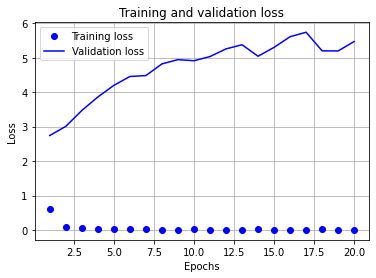

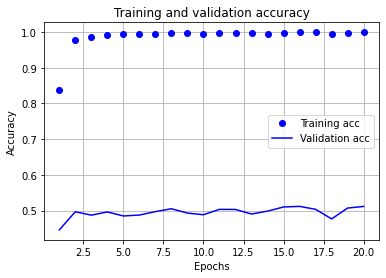

In [18]:
from matplotlib import pyplot as plt


epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)

fig = plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.savefig(str(path_img / run_id) + '-loss.png')

fig = plt.figure()
plt.plot(epochs, history.history['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.savefig(str(path_img / run_id) + '-accuracy.png')


with mlflow.start_run(run_id = run_id):
    mlflow.log_artifact(str(path_img / run_id) + '-loss.png')
    mlflow.log_artifact(str(path_img / run_id) + '-accuracy.png')    

In [19]:
import shutil
# shutil.make_archive(base_name='working', format='zip', base_dir='.')
shutil.make_archive(base_name='mlruns', format='zip', base_dir='./mlruns')

'mlruns.zip'